In [2]:
import numpy as np
import networkx as nx
import torch
import time
from sklearn.preprocessing import OneHotEncoder
from torch.autograd import Variable
from torch import nn
import matplotlib.pyplot as plt
from torch import autograd


In this part, we focus on a simple road map (rep as a graph below), and generate random path on it.
<img src="img/naive_road.png" alt="Drawing" style="width: 400px;"/>

In [3]:
def one_hot(x, N = 24):
    l = np.zeros(24)
    l[x] = 1
    return l
def inv_one_hot(l, N = 24):
    return np.argmax(l)

In [4]:
class road_graph():
    def __init__(self, graph_dict = {}):
        self.graph = self._build_graph(graph_dict)
    def _build_graph(self, graph_dict):
        nodes = list(graph_dict.keys())
        edges = [(m, n) for m in graph_dict.keys() for n in graph_dict[m]]
        G = nx.DiGraph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        return G
    @property
    def nodes(self):
        return np.array(self.graph.nodes)
    @property
    def edges(self):
        return np.array(self.graph.edges)
    def neighbors(self, node):
        return np.array(list(self.graph.neighbors(node)))
    def read_pathes(self, pathes):
        for p in pathes:
            self.graph.add_path(p)

In [5]:
def build_graph():
    G=nx.Graph()
    G.add_nodes_from(range(24))
    G.add_edges_from([(i, i+1) for i in range(5)] 
                     + [(i+6, i+7) for i in range(5)] 
                     +[(i+12, i+13) for i in range(5)]
                     + [(i+18, i+19) for i in range(5)]
                     + [(0,6),(6,12), (12,18)]
                     + [(pair[0]+1, pair[1]+1) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+2, pair[1]+2) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+3, pair[1]+3) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+4, pair[1]+4) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+5, pair[1]+5) for pair in [(0,6),(6,12), (12,18)]]
                     )
    return G

In [6]:
# gloable env
G = build_graph() 
N = len(G.node)

In [7]:
def random_path(start = None, stop_prob = 0.1):
    """
    Generate random path on graph G with lenght at least 2, encode each road in one-hot fashion
    """
    if not start:
        start = np.random.choice(24)
    path = [start]
    while True:
        nxt = np.random.choice(list(G.neighbors(start)))
        path.append(nxt)
        start = nxt
        if np.random.rand() < stop_prob:
            break
    return np.array(path)

In [8]:
p = random_path()
print(p)

[1 2 3]


In [9]:
def random_training_set():
    def f(x):
        if x == -1:
            return 0
        if x == -6:
            return 1
        if x == 1:
            return 2
        if x == 6:
            return 3
    path = random_path()
    inp = torch.from_numpy(np.float32(np.array([one_hot(p) for p in path[:-1]])))
    #import pdb; pdb.set_trace()
    tar = [f(x) for x in path[1:] - path[:-1]]
    tar = torch.from_numpy(np.array(tar))
    return Variable(inp).contiguous(), Variable(tar).contiguous()

In [10]:
def random_training_set_with_road_tar():
    path = random_path()
    inp = torch.from_numpy(np.float32(np.array([one_hot(p) for p in path[:-1]])))
    tar = torch.from_numpy(np.array(path[1:]))
    return Variable(inp).contiguous(), Variable(tar).contiguous()

In [11]:
x,y = random_training_set()
print('x: {} is the sequence of road'.format([inv_one_hot(r) for r in x.data.numpy()]))
print('y: {} denotes the turning decistion at each road'.format(y.data.numpy()))

x: [2, 1, 2, 3, 4] is the sequence of road
y: [0 2 2 2 3] denotes the turning decistion at each road


In [12]:
x,y = random_training_set_with_road_tar()
print('x: {} is the sequence of road'.format([inv_one_hot(r) for r in x.data.numpy()]))
print('y: {} is the sequence of road'.format(y.data.numpy()))

x: [16, 22, 21, 20, 19, 18, 19, 18, 12, 13, 7, 1, 2, 1, 7, 1, 0, 6, 0, 1, 0, 1, 7, 1, 0, 1, 7, 13, 12, 13, 14, 20, 19, 20, 14] is the sequence of road
y: [22 21 20 19 18 19 18 12 13  7  1  2  1  7  1  0  6  0  1  0  1  7  1  0  1
  7 13 12 13 14 20 19 20 14  8] is the sequence of road


In [13]:
x.size()

torch.Size([35, 24])

Since we know the road transition are markov (turing decision only depends on current road), let start with *none-recurrent nn* to fit our transition

In [14]:
N_batch, D_in, D_hidden, D_out = 50, 24, 100, 4
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(D_hidden, D_out),
    torch.nn.Softmax(dim = 1),
)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L = 0
n = 0
pts = {'x':[], 'y':[]}
for t in range(1,40001):
    x,y = random_training_set()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    L += sum(loss.data.numpy())
    n += len(loss.data.numpy())
    if t%1000 == 0:
        pts['x'].append(t)
        pts['y'].append(L/n)
        print(t, L/n)
        L = 0
        n = 0
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


1000 1.34625185013
2000 1.33895069474
3000 1.33143140155
4000 1.33189405662
5000 1.32945677936
6000 1.33116272372
7000 1.32713491887
8000 1.32930742294
9000 1.32882033712
10000 1.32825244045
11000 1.32690083325
12000 1.32740847117


KeyboardInterrupt: 

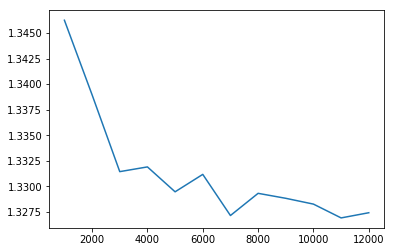

In [15]:
plt.plot(pts['x'],pts['y'])

In [16]:
x,y = random_training_set()
print([inv_one_hot(r) for r in x.data.numpy()])
model(x)

[14, 13, 19, 13]


Variable containing:
 0.2580  0.2586  0.2854  0.1981
 0.2682  0.2393  0.2920  0.2005
 0.4024  0.2531  0.3421  0.0023
 0.2682  0.2393  0.2920  0.2005
[torch.FloatTensor of size 4x4]